<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%EC%88%AB%EC%9E%90%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from torch.autograd import functional
import tensorflow as tf
from fastai.vision.all import *
from fastbook import *
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### GPU 설정

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6669715156962102300
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648737792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16175611283034275231
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


### 숫자 3과 7의 이미지 분류하는 모델

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
# 디렉터리 내용 확인
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [7]:
# 학습 데이터셋의 폴더 내용 확인
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [8]:
# 파일 순서가 같도록 정렬하기
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [9]:
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [10]:
# 손으로 쓴 숫자 3 이미지를 출력하기
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [11]:
# 이미지를 구성하는 숫자 확인
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [12]:
# 텐서로 표현
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [13]:
# 판다스 데이터프레임으로
# 숫자의 값에 따라 색상을
# 그라데이션으로 입히는 방법 보여주기
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


#### 픽셀 유사성

In [14]:
# 텐서 목록으로 구성된 리스트 생성하기
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

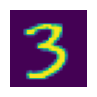

In [15]:
# 텐서 형태 이미지 출력하기
show_image(three_tensors[1]);

In [16]:
# 3차원 텐서(rank-3 tensor)로 결합하기
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [17]:
# 랭크 확인하기
len(stacked_threes.shape)

3

In [18]:
stacked_threes.ndim

3

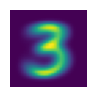

In [19]:
# 0번째 차원의 평균으로 모든 이미지 텐서의 평균 구하기
# 0번째 차원 : 이미지를 색인함.
mean3 = stacked_threes.mean(0)
show_image(mean3);

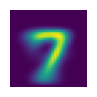

In [20]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

#### 거리 유사성 측정하기

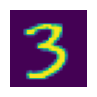

In [21]:
# 임의로 선택한 숫자3 샘플
a_3 = stacked_threes[1]
show_image(a_3);

In [22]:
# RMSE, MAD 모두 시행해보기
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [23]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [24]:
# 손실함수
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

#### 넘파이 배열과 파이토치 텐서

In [25]:
# 리스트로 배열/텐서 생성하기
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [26]:
# 넘파이
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [27]:
# 파이토치
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [28]:
tns[1]

tensor([4, 5, 6])

In [29]:
tns[:,1]

tensor([2, 5])

In [30]:
# 행/열의 일부분을 자유롭게 선택할 수 있음
tns[1,1:3]

tensor([5, 6])

In [31]:
# 표준 연산자
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [32]:
# 자료형 확인
tns.type()

'torch.LongTensor'

In [33]:
# 자료형 자동으로 바꾸기(정수>부동소수점)
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### 브로드캐스팅으로 평가지표 계산하기
- 브로드캐스팅 : 더 낮은 랭크의 텐서를 더 높은 텐서와 같은 크기로 자동 확장

In [34]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
# 크기(모양) 확인
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [35]:
# 평균절대오차를 계산하는 함수 구현
def mnist_distance(a,b) :
  return (a-b).abs().mean((-1,-2))

mnist_distance(a_3, mean3)

tensor(0.1114)

In [36]:
# 검증용 데이터셋 모두에 대해 거리 적용하기
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1590, 0.1102, 0.1366,  ..., 0.1344, 0.1599, 0.1160]),
 torch.Size([1010]))

In [37]:
# 브로드캐스팅 예시
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [38]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [39]:
# is_3() 구현하기
def is_3(x) :
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [40]:
# 실험해보기
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [41]:
# 검증용 데이터셋에서 실험
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True, False,  True])

In [42]:
# 정확도 계산하기
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### 확률적 경사 하강법

In [43]:
# 숫자 3이 될 확률
def pr_three(x,w) :
  return (x*w).sum()

#### 간단한 예시

In [44]:
# 2차 함수 정의
def f(x) :
  return x**2

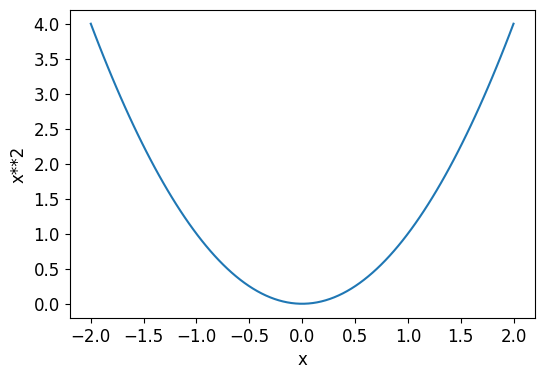

In [45]:
# 그래프 그리기
plot_function(f, 'x', 'x**2')

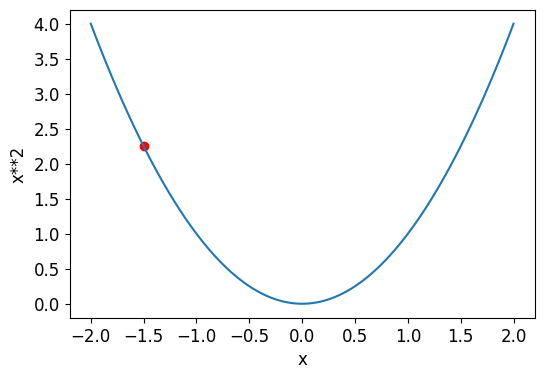

In [46]:
# 임의의 파라미터 값을 선택하고 손실값을 계산
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

#### 파이토치 자동미분

In [47]:
xt = tensor(3.).requires_grad_()

In [48]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [49]:
# 그레디언트 계산
yt.backward()

In [50]:
# 계산된 그레디언트 확인
xt.grad

tensor(6.)

In [51]:
# 벡터를 입력해서 그레디언트 구하기
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [52]:
# 벡터가 입력되었을 때 스칼라값을 출력하는 함수
def f(x) :
  return (x**2).sum()

In [53]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [54]:
# 그레디언트 구하기
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

#### SGD를 활용해보기

In [128]:
# 20초 동안 매초에 수작업으로 속력을 측정
time = torch.arange(0,20).float();
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

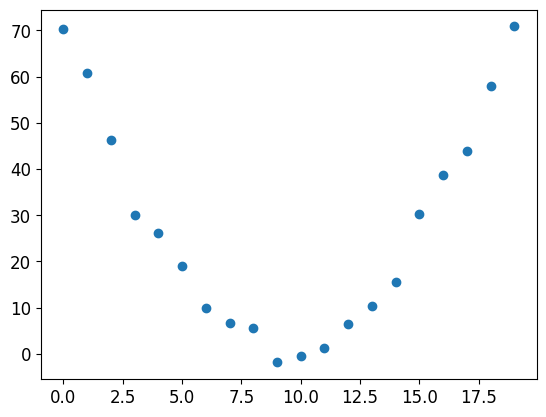

In [129]:
# 임의의 노이즈 추가
speed = torch.randn(20) * 3 + 0.75 * (time-9.5)**2 + 1
plt.scatter(time, speed);

In [130]:
# 모든 파라미터는 하나의 함수 인자로 담기
def f(t, params) :
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [131]:
# 손실 함수 정의
def mse(preds, targets) :
  return ((preds-targets)**2).mean().sqrt()

##### 1. 파라미터 초기화

In [132]:
params = torch.randn(3).requires_grad_()

##### 2. 예측 계산

In [133]:
preds = f(time, params)

In [134]:
# 예측과 실제 타깃의 유사도를 그래프로 그리는 함수
def show_preds(preds, ax=None) :
  if ax is None :
    ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)

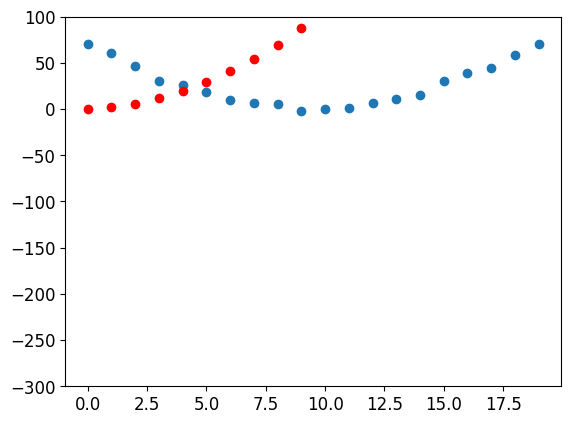

In [135]:
show_preds(preds)

##### 3. 손실 계산

In [136]:
loss = mse(preds, speed)
loss

tensor(150.7024, grad_fn=<SqrtBackward0>)

##### 4. 그레디언트 계산

In [137]:
loss.backward()
params.grad

tensor([165.0637,  10.6510,   0.6726])

In [138]:
# 학습률 적용 : 계산된 그레디언트로 파라미터 개선
params.grad * 1e-5

tensor([1.6506e-03, 1.0651e-04, 6.7257e-06])

In [139]:
params

tensor([ 0.9652,  1.0090, -0.0337], requires_grad=True)

##### 5. 가중치를 한 단계 계산하기

In [140]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [141]:
# 손실 개선 확인하기
preds = f(time, params)
mse(preds, speed)

tensor(150.4288, grad_fn=<SqrtBackward0>)

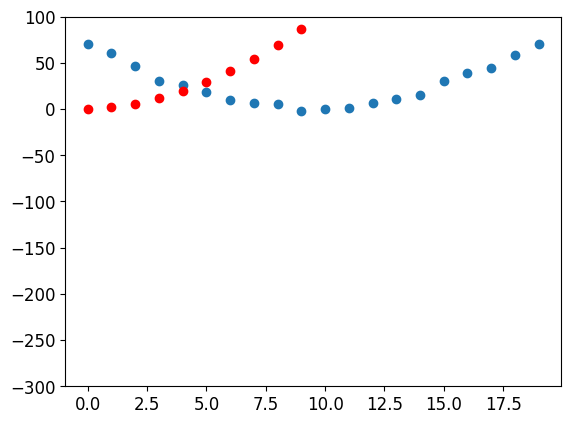

In [142]:
show_preds(preds)

In [143]:
# 모든 과정을 담은 함수 만들기
def apply_step(params, prn=True) :
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= params.grad.data
  params.grad = None
  if prn :
    print(loss.item())
  return preds

##### 6. 과정 반복하기

In [144]:
for i in range(10) :
  apply_step(params)

150.4287872314453
27651.572265625
598.7077026367188
27623.44921875
626.8016357421875
27597.81640625
652.4073486328125
27574.17578125
676.0311889648438
27552.171875


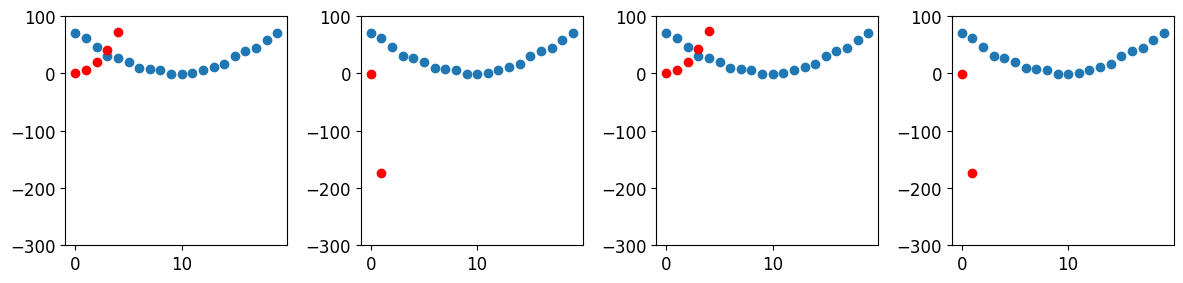

In [146]:
# 시각화
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs :
  show_preds(apply_step(params, False), ax)
plt.tight_layout()

### MNIST 손실함수

In [149]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [161]:
# 각 이미지의 레이블(3:1, 7:0)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [163]:
# zip()함수를 list와 함께 사용하면 튜플을 간단히 구성할 수 있음.
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [164]:
# 검증용 데이터
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [165]:
valid_dset = list(zip(valid_x, valid_y))

In [167]:
# 각 픽셀에 임의로 초기화된 가중치가 필요함
def init_params(size, std=1.0) :
  return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))